In [11]:
from pymongo import MongoClient
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
client = MongoClient("mongodb://localhost:27017")

In [58]:
# Access a database
db = client.get_database("RECSYS")

# Access a collection
collection = db.get_collection("ARS")
cursor = collection.find()
data_from_mongodb = list(cursor)

In [59]:
import pandas as pd
# Convert the list of dictionaries to a pandas DataFrame
df1 = pd.DataFrame(data_from_mongodb)

In [6]:
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2190 rows and 10 columns


In [7]:
df1.head(5)

,_id,,Unnamed: 0,link,text,title,date,keywords,summary,title_summary
0,65588c8a46e1b31d6cf5b3d7,0,0,http://techcrunch.com/2020/09/07/vodafone-idea...,"Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...,2020-09-07 00:00:00,"['rebrands', 'idea', 'vi', 'giant', 'brand', '...","Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...
1,65588c8a46e1b31d6cf5b3d8,1,1,http://techcrunch.com/2020/09/16/facebook-addr...,"At the beginning of the previous decade, Faceb...",Facebook addresses political controversy in In...,2020-09-16 00:00:00,"['opportunities', 'whatsapp', 'controversy', '...",Politicians in the country today heavily rely ...,Facebook addresses political controversy in In...
2,65588c8a46e1b31d6cf5b3d9,2,2,http://techcrunch.com/2020/09/14/youtube-launc...,"As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho...",2020-09-14 00:00:00,"['rival', 'video', 'feature', 'access', 'youtu...","As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho..."
3,65588c8a46e1b31d6cf5b3da,3,3,http://techcrunch.com/2020/09/09/groww-an-inve...,Even as more than 150 million people are using...,"Groww, an investment app for millennials in In...",2020-09-09 00:00:00,"['world', 'yc', 'continuity', 'stocks', 'groww...","YC Continuity, the growth-stage investment fun...","Groww, an investment app for millennials in In..."
4,65588c8a46e1b31d6cf5b3db,4,4,http://techcrunch.com/2020/09/15/lanzatech-is-...,As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...,2020-09-15 00:00:00,"['production', 'distributed', 'developing', 's...",As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...


In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [60]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df1
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
    

In [12]:
plotPerColumnDistribution(df1, 10, 5)

<Figure size 2400x512 with 0 Axes>

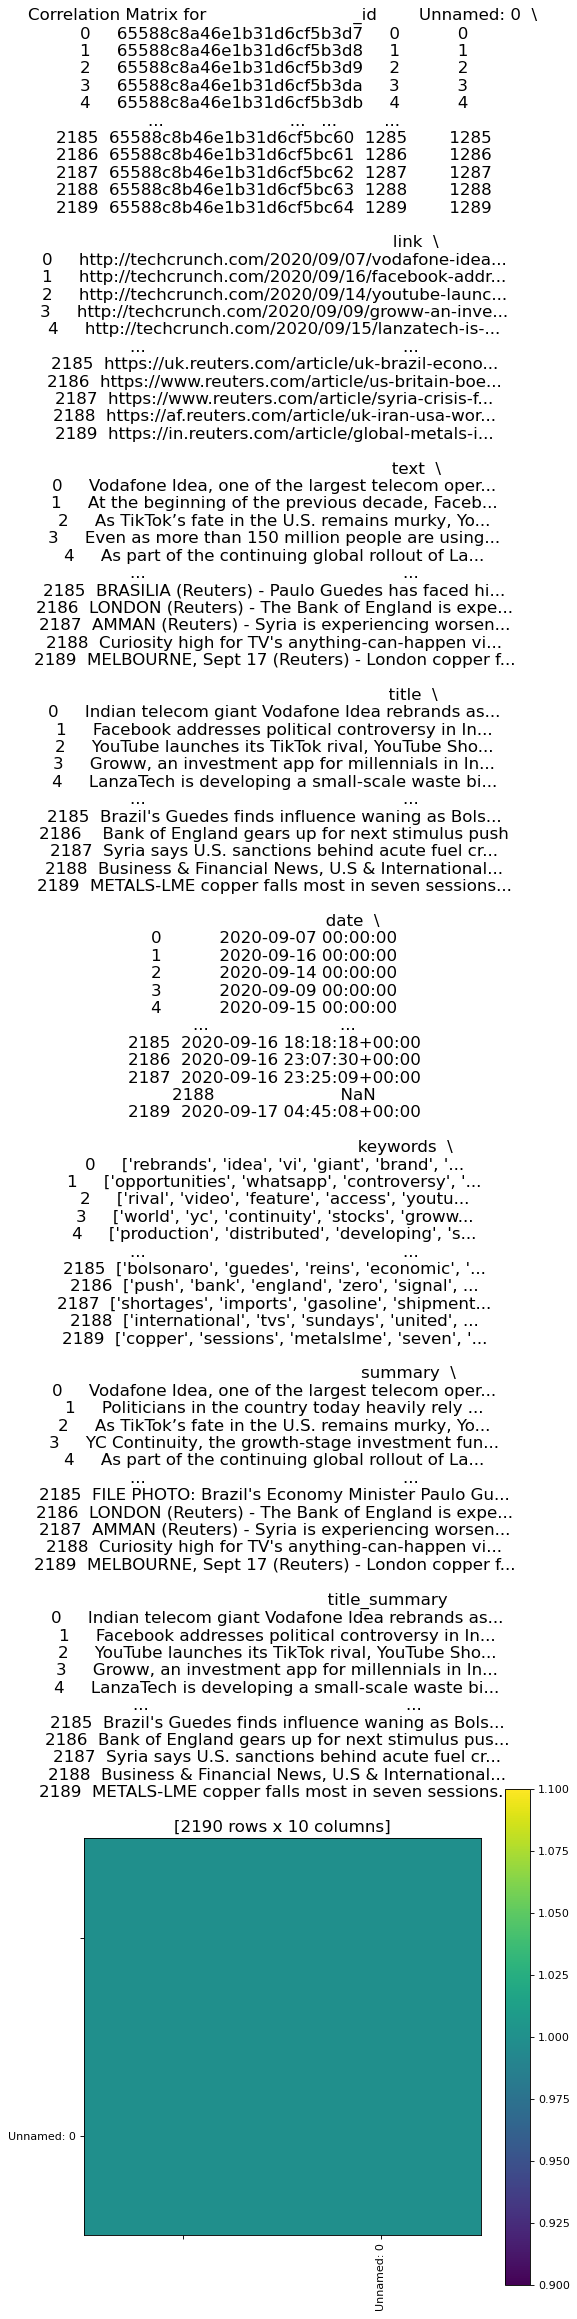

In [61]:
plotCorrelationMatrix(df1, 8)

<AxesSubplot:xlabel='month,day'>

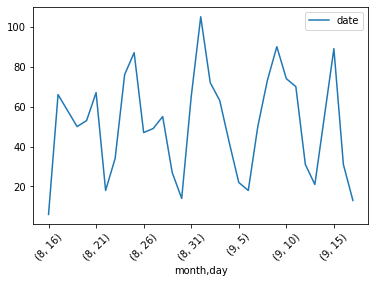

In [14]:
date = df1['date']
dates = pd.DataFrame({'date' : date})
dates['date'] = pd.to_datetime(dates['date'], utc = True)
dates['day'] = dates.date.dt.day
dates['month'] = dates.date.dt.month
dates = dates.convert_dtypes()
dates.groupby(['month','day']).agg('count').plot(rot = 45)

# Data Preprocessing
Data cleaning and selecting few columns we will be requiring for the recomendation

In [62]:
data = df1
data = data.drop_duplicates(subset=None, keep='first', inplace=False)
data.shape

(2190, 10)

In [63]:
data.insert(0,'id',range(0,data.shape[0]))
data

,id,_id,,Unnamed: 0,link,text,title,date,keywords,summary,title_summary
0,0,65588c8a46e1b31d6cf5b3d7,0,0,http://techcrunch.com/2020/09/07/vodafone-idea...,"Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...,2020-09-07 00:00:00,"['rebrands', 'idea', 'vi', 'giant', 'brand', '...","Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...
1,1,65588c8a46e1b31d6cf5b3d8,1,1,http://techcrunch.com/2020/09/16/facebook-addr...,"At the beginning of the previous decade, Faceb...",Facebook addresses political controversy in In...,2020-09-16 00:00:00,"['opportunities', 'whatsapp', 'controversy', '...",Politicians in the country today heavily rely ...,Facebook addresses political controversy in In...
2,2,65588c8a46e1b31d6cf5b3d9,2,2,http://techcrunch.com/2020/09/14/youtube-launc...,"As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho...",2020-09-14 00:00:00,"['rival', 'video', 'feature', 'access', 'youtu...","As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho..."
3,3,65588c8a46e1b31d6cf5b3da,3,3,http://techcrunch.com/2020/09/09/groww-an-inve...,Even as more than 150 million people are using...,"Groww, an investment app for millennials in In...",2020-09-09 00:00:00,"['world', 'yc', 'continuity', 'stocks', 'groww...","YC Continuity, the growth-stage investment fun...","Groww, an investment app for millennials in In..."
4,4,65588c8a46e1b31d6cf5b3db,4,4,http://techcrunch.com/2020/09/15/lanzatech-is-...,As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...,2020-09-15 00:00:00,"['production', 'distributed', 'developing', 's...",As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...
...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,65588c8b46e1b31d6cf5bc60,1285,1285,https://uk.reuters.com/article/uk-brazil-econo...,BRASILIA (Reuters) - Paulo Guedes has faced hi...,Brazil's Guedes finds influence waning as Bols...,2020-09-16 18:18:18+00:00,"['bolsonaro', 'guedes', 'reins', 'economic', '...",FILE PHOTO: Brazil's Economy Minister Paulo Gu...,Brazil's Guedes finds influence waning as Bols...
2186,2186,65588c8b46e1b31d6cf5bc61,1286,1286,https://www.reuters.com/article/us-britain-boe...,LONDON (Reuters) - The Bank of England is expe...,Bank of England gears up for next stimulus push,2020-09-16 23:07:30+00:00,"['push', 'bank', 'england', 'zero', 'signal', ...",LONDON (Reuters) - The Bank of England is expe...,Bank of England gears up for next stimulus pus...
2187,2187,65588c8b46e1b31d6cf5bc62,1287,1287,https://www.reuters.com/article/syria-crisis-f...,AMMAN (Reuters) - Syria is experiencing worsen...,Syria says U.S. sanctions behind acute fuel cr...,2020-09-16 23:25:09+00:00,"['shortages', 'imports', 'gasoline', 'shipment...",AMMAN (Reuters) - Syria is experiencing worsen...,Syria says U.S. sanctions behind acute fuel cr...
2188,2188,65588c8b46e1b31d6cf5bc63,1288,1288,https://af.reuters.com/article/uk-iran-usa-wor...,Curiosity high for TV's anything-can-happen vi...,"Business & Financial News, U.S & International...",NaN,"['international', 'tvs', 'sundays', 'united', ...",Curiosity high for TV's anything-can-happen vi...,"Business & Financial News, U.S & International..."


In [64]:
ds = data[['date','title','text','link']]
ds = ds.dropna()
ds = ds.drop_duplicates(subset=None, keep='first', inplace=False)
ds.insert(0,'id',range(0,ds.shape[0]))
ds.shape
ds.head()

,id,date,title,text,link
0,0,2020-09-07 00:00:00,Indian telecom giant Vodafone Idea rebrands as...,"Vodafone Idea, one of the largest telecom oper...",http://techcrunch.com/2020/09/07/vodafone-idea...
1,1,2020-09-16 00:00:00,Facebook addresses political controversy in In...,"At the beginning of the previous decade, Faceb...",http://techcrunch.com/2020/09/16/facebook-addr...
2,2,2020-09-14 00:00:00,"YouTube launches its TikTok rival, YouTube Sho...","As TikTok’s fate in the U.S. remains murky, Yo...",http://techcrunch.com/2020/09/14/youtube-launc...
3,3,2020-09-09 00:00:00,"Groww, an investment app for millennials in In...",Even as more than 150 million people are using...,http://techcrunch.com/2020/09/09/groww-an-inve...
4,4,2020-09-15 00:00:00,LanzaTech is developing a small-scale waste bi...,As part of the continuing global rollout of La...,http://techcrunch.com/2020/09/15/lanzatech-is-...


## Step 2: Encoding your data

There are a number of popular encoding schemes but the main ones are:
### One-hot encoding
### Term frequency–inverse document frequency (TF-IDF) encoding
### Word embeddings
For our example, we will use the term frequency–inverse document frequency (TF-IDF) encoding scheme.\
The advantage of TF-IDF encoding is that it will weigh a term (a tag for a movie in our example) according to the importance of the term within the document: The more frequently the term appears, the larger its weight will be. At the same time, it weighs the item inversely to the frequency of this term across the entire dataset: It will emphasise terms that are relatively rare occurrences in the general dataset but of importance to the specific content at hand.

In [18]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
ds['cleaned_desc'] = ds['text'].apply(func = make_lower_case)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func = remove_stop_words)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func=remove_punctuation)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func=remove_html)


In [20]:
# Create the TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.8, min_df=0.0, use_idf=True, ngram_range=(1, 3))
tfidf_matrix = tf.fit_transform(ds['cleaned_desc'])

# Get feature names
feature_names = tf.get_feature_names_out()

# Create a DataFrame from the tfidf_matrix
pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

,aa,aa batteries,aa batteries set,aa lithium,aa lithium later,aaa,aaa affirmed,aaa affirmed shubhshree,aaa titles,aaa titles hard,...,zwift prides,zwift prides ability,zwift raised,zwift raised million,𝗺𝗼𝗻𝘁𝗵,𝗺𝗼𝗻𝘁𝗵 pandemic,𝗺𝗼𝗻𝘁𝗵 pandemic sustain,𝗽𝗲𝗿,𝗽𝗲𝗿 𝗺𝗼𝗻𝘁𝗵,𝗽𝗲𝗿 𝗺𝗼𝗻𝘁𝗵 pandemic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Content Based Recomendation

# Vector Space Model

### The method of calculating the user’s likes / dislikes / measures is calculated by taking the cosine of the angle between the user profile vector (Ui ) and the document vector; or in our case, the angle between two document vectors.
### The ultimate reason behind using cosine is that the value of cosine will increase as the angle between vectors with decreases, which signifies more similarity.

In [21]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
results = {}

# Iterate through the indices that match the size of cosine_similarities
for idx in range(len(ds)):
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], i) for i in similar_indices]
    results[idx] = similar_items[1:]

print('done!')

done!


In [22]:
similar_indices[:100]

array([1495,   37,  237,  987,  148,  818,  151, 1341, 1448,  835,   33,
       1188, 1189, 1153, 1151, 1357,  115,  299, 1139, 1145,  260,  265,
        191, 1136,  249,   36, 1113,  998, 1109, 1106, 1349, 1362, 1356,
        114,  997, 1265, 1368,  192, 1142,   48,  262, 1171, 1437, 1304,
        194, 1390,  137, 1351,  169, 1303, 1206, 1388, 1134,  959, 1027,
        127, 1364,  112, 1111, 1105,   39,  983,  984, 1272,  120,  293,
       1156, 1161, 1062, 1150, 1386, 1290, 1148, 1205, 1141,  155,  921,
        920,   31, 1387, 1467, 1477, 1162,  292, 1471, 1137,  972, 1365,
       1360, 1382, 1314, 1493, 1144, 1155, 1352, 1397,  288,  282,  882],
      dtype=int64)

In [23]:
def item(id):
    return ds.loc[ds['id'] == id]['title'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")
    print("-------")
    recs = results[item_id][:num]
    for rec in recs:
        print("Recommended : " + item(rec[1]) + " (score:" + str(rec[0]) + ")",end='\n\n')

recommend(item_id=10, num=15)

Recommending 15 products similar to Oracle boots out Microsoft and wins bid for TikTok, reports say – TechCrunch...
-------
Recommended : 'Oracle just completely saved the day': TikTok users react to looming deal (score:0.13580803689723356)

Recommended : Exclusive: ByteDance investors seek to use stakes to finance TikTok bid (score:0.12284005861903849)

Recommended : Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch (score:0.10455458088685966)

Recommended : Charli D'Amelio joins Triller, TikTok's rival app (score:0.09657684997001588)

Recommended : Stocks of TikTok U.S. suitors hit by fears of China block (score:0.08275825819343734)

Recommended : Stocks of TikTok U.S. suitors hit by fears of China block (score:0.08275825819343734)

Recommended : TikTok hits 100M users in Europe as the clock ticks on its US business – TechCrunch (score:0.07238732230560915)

Recommended : China's new tech export controls could give Beijing a say in TikTok sale (score:0.06656

In [24]:
cosine_similarities

array([[1.00000000e+00, 5.02689585e-02, 7.40465108e-03, ...,
        2.83329826e-03, 2.52771507e-03, 4.38640282e-03],
       [5.02689585e-02, 1.00000000e+00, 2.01145092e-02, ...,
        5.55984926e-03, 6.30472309e-03, 2.22964674e-03],
       [7.40465108e-03, 2.01145092e-02, 1.00000000e+00, ...,
        2.41903652e-03, 7.02318301e-04, 3.98714537e-03],
       ...,
       [2.83329826e-03, 5.55984926e-03, 2.41903652e-03, ...,
        1.00000000e+00, 4.74725861e-03, 1.17202792e-02],
       [2.52771507e-03, 6.30472309e-03, 7.02318301e-04, ...,
        4.74725861e-03, 1.00000000e+00, 2.88005595e-03],
       [4.38640282e-03, 2.22964674e-03, 3.98714537e-03, ...,
        1.17202792e-02, 2.88005595e-03, 1.00000000e+00]])

In [65]:
df1.head(2)

,_id,,Unnamed: 0,link,text,title,date,keywords,summary,title_summary
0,65588c8a46e1b31d6cf5b3d7,0,0,http://techcrunch.com/2020/09/07/vodafone-idea...,"Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...,2020-09-07 00:00:00,"['rebrands', 'idea', 'vi', 'giant', 'brand', '...","Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...
1,65588c8a46e1b31d6cf5b3d8,1,1,http://techcrunch.com/2020/09/16/facebook-addr...,"At the beginning of the previous decade, Faceb...",Facebook addresses political controversy in In...,2020-09-16 00:00:00,"['opportunities', 'whatsapp', 'controversy', '...",Politicians in the country today heavily rely ...,Facebook addresses political controversy in In...


In [26]:
def recomendation(idx,no_of_news_article):
    #get similarity values with other articles
    similarity_score = list(enumerate(cosine_similarities[idx]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the n most similar news articles. Ignore the first movie.
    similarity_score = similarity_score[1:no_of_news_article+1]

    print("Article Read -- " + ds['title'].iloc[idx] +" link --"+ ds['link'].iloc[idx])
    print(" ---------------------------------------------------------- ")
    news_indices = [i[0] for i in similarity_score]
    for i in range(len(news_indices)):
        print("Recomendation "+ str(i+1)+" --- " +str(news_indices[i])+"(IDX)  "+str(ds['date'].iloc[news_indices[i]])+" : "+
              ds['title'].iloc[news_indices[i]] +" || Link --"+ ds['link'].iloc[news_indices[i]] +" score -- "+ str(similarity_score[i][1]))
        print()

In [27]:
idx=3  #min_df=0.2 shape 1496 rows × 31 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

Article Read -- Groww, an investment app for millennials in India, raises $30M led by YC Continuity – TechCrunch link --http://techcrunch.com/2020/09/09/groww-an-investment-app-for-millennials-in-india-raises-30m-led-by-yc-continuity/
 ---------------------------------------------------------- 
Recomendation 1 --- 176(IDX)  2020-09-02 00:00:00 : 3one4 Capital launches $100M fund to back early-stage startups in India – TechCrunch || Link --http://techcrunch.com/2020/09/02/3one4-capital-launches-100m-fund-to-back-early-stage-startups-in-india/ score -- 0.05712325226508238

Recomendation 2 --- 9(IDX)  2020-09-07 00:00:00 : Silver Lake leads $500 million investment round in Indian online learning giant Byju’s – TechCrunch || Link --http://techcrunch.com/2020/09/07/silver-lake-leads-500-million-round-in-indias-byjus/ score -- 0.05012420506583725

Recomendation 3 --- 7(IDX)  2020-09-15 00:00:00 : Virtual events platform Airmeet raises $12M – TechCrunch || Link --http://techcrunch.com/2020/09

In [28]:
idx=7
no_of_news_article=10
recomendation(idx,no_of_news_article)

Article Read -- Virtual events platform Airmeet raises $12M – TechCrunch link --http://techcrunch.com/2020/09/15/virtual-events-platform-airmeet-raises-12m/
 ---------------------------------------------------------- 
Recomendation 1 --- 178(IDX)  2020-08-31 00:00:00 : Chan Zuckerberg Initiative backs Indian education startup Eruditus in $113 million fundraise – TechCrunch || Link --http://techcrunch.com/2020/08/31/chan-zuckerberg-initiative-backs-indian-education-startup-eruditus-in-113-million-fundraise/ score -- 0.0495454771990727

Recomendation 2 --- 3(IDX)  2020-09-09 00:00:00 : Groww, an investment app for millennials in India, raises $30M led by YC Continuity – TechCrunch || Link --http://techcrunch.com/2020/09/09/groww-an-investment-app-for-millennials-in-india-raises-30m-led-by-yc-continuity/ score -- 0.04860331628063638

Recomendation 3 --- 9(IDX)  2020-09-07 00:00:00 : Silver Lake leads $500 million investment round in Indian online learning giant Byju’s – TechCrunch || Link

In [29]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 19.8 s


In [30]:
ds.insert(2,'cluster',clusters)

In [31]:
ds['cluster'].value_counts()

3    951
4    393
0     82
2     59
1     11
Name: cluster, dtype: int64

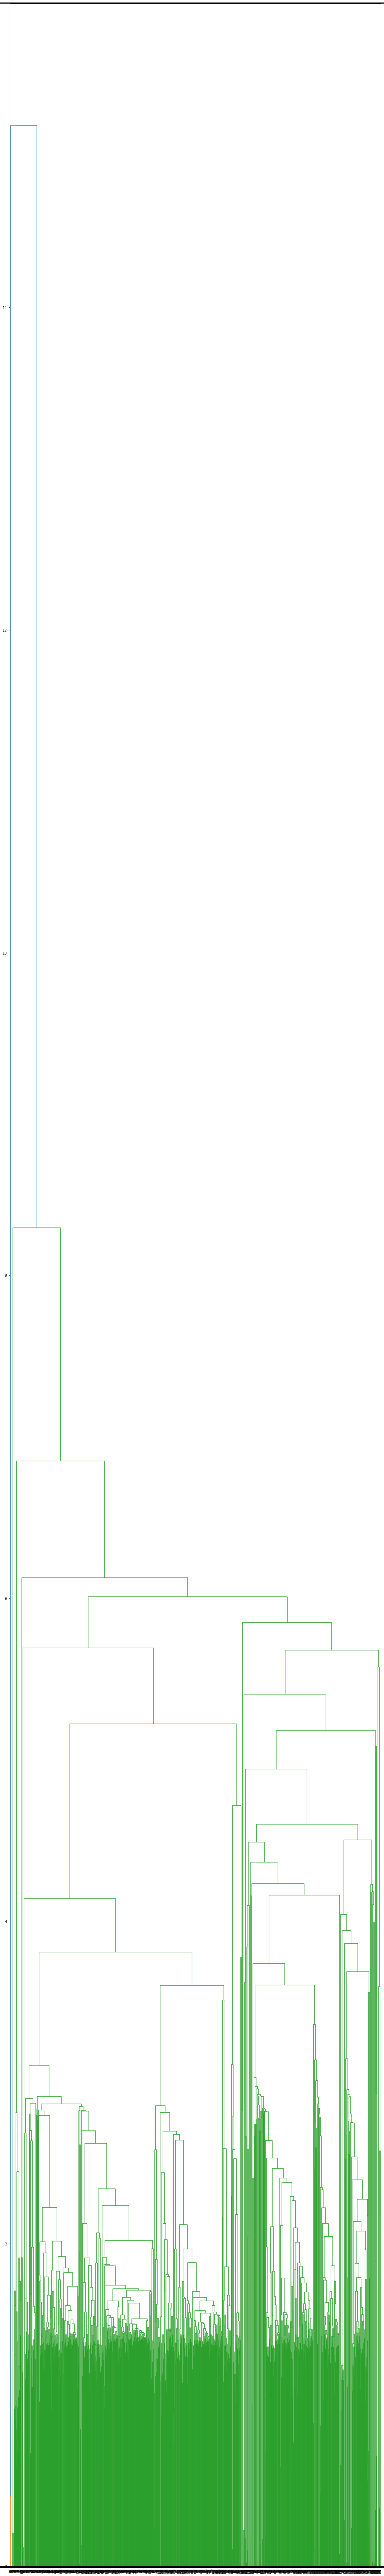

In [32]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 100)) # set size
ax = dendrogram(linkage_matrix)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
               width=10000)

plt.tight_layout()

# Topic Classification Model

In [51]:
    # Access a collection
collection1 = db.get_collection("class")
cursor1 = collection1.find()
data_from_mongodb1 = list(cursor1)

In [52]:
data = pd.DataFrame(data_from_mongodb1)

In [53]:
data.head(4)

,_id,label,cleantext
0,6558943f46e1b31d6cf5bc66,sport,moment closing send rodriguez jorge jaguares h...
1,6558943f46e1b31d6cf5bc67,sport,monday on train maybe say platt available nast...
2,6558943f46e1b31d6cf5bc68,sport,event 15team seeding final determine saturday ...
3,6558943f46e1b31d6cf5bc69,sport,city manchester dzeko edin sale compensating o...


In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [54]:
print(data['cleantext'].dtype)


object


In [55]:
data['cleantext'] = data['cleantext'].astype(str)


In [42]:
# Load and preprocess your dataset
# Assuming you have a DataFrame 'data' with 'cleantext' and 'label' columns

# Encode class labels to integers
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleantext'], data['label_encoded'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=6)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
y_pred_original = label_encoder.inverse_transform(y_pred)  # Convert predictions back to original labels
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7369
           1       0.58      0.88      0.70      7551
           2       0.90      0.77      0.83      5635
           3       0.83      0.61      0.70      4670
           4       0.21      0.01      0.02       866
           5       0.82      0.19      0.31      1198

    accuracy                           0.74     27289
   macro avg       0.70      0.55      0.57     27289
weighted avg       0.76      0.74      0.73     27289



In [43]:
import pickle
# Save the XGBoost model to a file
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the LabelEncoder to a file
with open('label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

# Save the TfidfVectorizer to a file
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

# Use the loaded model for predictions
# y_pred = loaded_model.predict(X_test_tfidf)

In [66]:
# idx=7  #min_df=0.1  shape 1496 rows × 144 columns
# no_of_news_article=10
# recomendation(idx,no_of_news_article)

## CODE for getting recomendations
df1.head()

,_id,,Unnamed: 0,link,text,title,date,keywords,summary,title_summary
0,65588c8a46e1b31d6cf5b3d7,0,0,http://techcrunch.com/2020/09/07/vodafone-idea...,"Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...,2020-09-07 00:00:00,"['rebrands', 'idea', 'vi', 'giant', 'brand', '...","Vodafone Idea, one of the largest telecom oper...",Indian telecom giant Vodafone Idea rebrands as...
1,65588c8a46e1b31d6cf5b3d8,1,1,http://techcrunch.com/2020/09/16/facebook-addr...,"At the beginning of the previous decade, Faceb...",Facebook addresses political controversy in In...,2020-09-16 00:00:00,"['opportunities', 'whatsapp', 'controversy', '...",Politicians in the country today heavily rely ...,Facebook addresses political controversy in In...
2,65588c8a46e1b31d6cf5b3d9,2,2,http://techcrunch.com/2020/09/14/youtube-launc...,"As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho...",2020-09-14 00:00:00,"['rival', 'video', 'feature', 'access', 'youtu...","As TikTok’s fate in the U.S. remains murky, Yo...","YouTube launches its TikTok rival, YouTube Sho..."
3,65588c8a46e1b31d6cf5b3da,3,3,http://techcrunch.com/2020/09/09/groww-an-inve...,Even as more than 150 million people are using...,"Groww, an investment app for millennials in In...",2020-09-09 00:00:00,"['world', 'yc', 'continuity', 'stocks', 'groww...","YC Continuity, the growth-stage investment fun...","Groww, an investment app for millennials in In..."
4,65588c8a46e1b31d6cf5b3db,4,4,http://techcrunch.com/2020/09/15/lanzatech-is-...,As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...,2020-09-15 00:00:00,"['production', 'distributed', 'developing', 's...",As part of the continuing global rollout of La...,LanzaTech is developing a small-scale waste bi...


# Collabrative Method

In [67]:
#df1 = df1.drop(['Unnamed: 0'],axis=1)
# Rename 'Unnamed: 0.1' to 'UserId'
data = df1
data.rename(columns={'Unnamed: 0': 'UserId'}, inplace=True)
# Create a user-item interaction matrix

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Drop duplicates based on 'UserId' and 'title'
df1 = df1.drop_duplicates(subset=['UserId', 'title'])

# Fill missing values in the 'title' column with an empty string
df1['title'] = df1['title'].fillna('')

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.8, min_df=0.0, use_idf=True, ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(df1['title'])

# Calculate cosine similarity between users based on the title
user_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get similar users
def get_similar_users(user_id, user_similarity_matrix, n=5):
    user_idx = df1[df1['UserId'] == user_id].index[0]
    similar_users = user_similarity_matrix[user_idx]
    similar_users_idx = similar_users.argsort()[-n-1:-1][::-1]  # Exclude the user itself
    return similar_users_idx

# Function to recommend items to a user based on similar users
def recommend_items(user_id, user_similarity_matrix, df, n=5):
    similar_users_idx = get_similar_users(user_id, user_similarity_matrix, n)

    user_items = set(df[df['UserId'] == user_id]['title'])
    recommendations = []

    for similar_user_idx in similar_users_idx:
        similar_user_items = set(df[df.index == similar_user_idx]['title'])
        unrated_items = similar_user_items - user_items
        recommendations.extend(unrated_items)

        if len(recommendations) >= n:
            break

    return recommendations[:n]

# Example: Recommend items for User 40
user_id_to_recommend = 40
recommended_items = recommend_items(user_id_to_recommend, user_similarity, df1)

# Display the recommendations
print(f"Recommendations for User {user_id_to_recommend}:")
for item in recommended_items:
    print(f"- {item}")


Recommendations for User 40:
- U.S. Open day three
- Top Photos of the Day
- Top Photos of the Day
- We read Michael Cohen's book on Trump so you don't have to. But you should.
- Go read this CNET story about the Avengers game that wasn’t


In [68]:
user_id_to_recommend = 10
recommended_items = recommend_items(user_id_to_recommend, user_similarity, df1)

# Display the recommendations
print(f"Recommendations for User {user_id_to_recommend}:")
for item in recommended_items:
    print(f"- {item}")

Recommendations for User 10:
- Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch
- Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch
- Exclusive: ByteDance investors seek to use stakes to finance TikTok bid
- 'Oracle just completely saved the day': TikTok users react to looming deal


In [69]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Combine recommendations from both methods
def hybrid_recommendation(user_id, collaborative_recommendations, content_based_recommendations, n=10):
    combined_recommendations = []

    # Combine recommendations and assign weights (you can adjust weights based on performance)
    for i in range(n):
        if i < len(collaborative_recommendations):
            item_id_collab = collaborative_recommendations[i]
            score_collab = 1.0  # Placeholder score for collaborative recommendations
        else:
            score_collab = 0.0
            item_id_collab = None

        if i < len(content_based_recommendations):
            score_content, item_id_content = content_based_recommendations[i]
        else:
            score_content = 0.0
            item_id_content = None

        # Assign weights (you can adjust these)
        weight_collab = 0.6
        weight_content = 0.4

        # Calculate the combined score
        combined_score = (weight_collab * score_collab) + (weight_content * score_content)

        # Append the combined recommendation with its score
        combined_recommendations.append((combined_score, item_id_collab or item_id_content))

    # Sort the combined recommendations by score
    combined_recommendations = sorted(combined_recommendations, key=lambda x: x[0], reverse=True)

    return combined_recommendations

# Example: Get collaborative recommendations for User 40
user_id_to_recommend = 40
collaborative_recommendations = recommend_items(user_id_to_recommend, user_similarity, df1)

# Example: Get content-based recommendations for item_id 10
content_based_recommendations = results[10][:10]  # Assuming you want 5 recommendations

# Example: Get hybrid recommendations
hybrid_recommendations = hybrid_recommendation(user_id_to_recommend, collaborative_recommendations, content_based_recommendations)

# Display the hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for score, item_id in hybrid_recommendations:
    print(f"- Item {item_id} with combined score {score}")

Hybrid Recommendations for User 40:
- Item U.S. Open day three with combined score 0.6543232147588934
- Item Top Photos of the Day with combined score 0.6491360234476153
- Item Top Photos of the Day with combined score 0.6418218323547439
- Item We read Michael Cohen's book on Trump so you don't have to. But you should. with combined score 0.6386307399880063
- Item Go read this CNET story about the Avengers game that wasn’t with combined score 0.633103303277375
- Item 1041 with combined score 0.033103303277374936
- Item 16 with combined score 0.02895492892224366
- Item 1047 with combined score 0.026625525960567015
- Item 1048 with combined score 0.026625525960567015
- Item 257 with combined score 0.025228856451860238


In [70]:
# Example: Get collaborative recommendations for User 40
user_id_to_recommend = 10
collaborative_recommendations = recommend_items(user_id_to_recommend, user_similarity, df1)

# Example: Get content-based recommendations for item_id 10
content_based_recommendations = results[10][:10]  # Assuming you want 5 recommendations

# Example: Get hybrid recommendations
hybrid_recommendations = hybrid_recommendation(user_id_to_recommend, collaborative_recommendations, content_based_recommendations)

# Display the hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for score, item_id in hybrid_recommendations:
    print(f"- Item {item_id} with combined score {score}")

Hybrid Recommendations for User 10:
- Item Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch with combined score 0.6543232147588934
- Item Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch with combined score 0.6491360234476153
- Item Exclusive: ByteDance investors seek to use stakes to finance TikTok bid with combined score 0.6418218323547439
- Item 'Oracle just completely saved the day': TikTok users react to looming deal with combined score 0.6386307399880063
- Item 1038 with combined score 0.033103303277374936
- Item 1041 with combined score 0.033103303277374936
- Item 16 with combined score 0.02895492892224366
- Item 1047 with combined score 0.026625525960567015
- Item 1048 with combined score 0.026625525960567015
- Item 257 with combined score 0.025228856451860238


In [71]:
# Get the top 5 recommendations from hybrid recommendations
top_hybrid_recommendations = hybrid_recommendations[:5]

# Extract item_ids from the recommendations
top_item_ids = [item_id for score, item_id in top_hybrid_recommendations]

# Display the top 5 recommended item_ids
print("Top 5 Recommended Item IDs:")
print(top_item_ids)

Top 5 Recommended Item IDs:
['Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch', 'Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch', 'Exclusive: ByteDance investors seek to use stakes to finance TikTok bid', "'Oracle just completely saved the day': TikTok users react to looming deal", 1038]


In [72]:
# Assuming df is your dataset
search_title = 'Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch'
df = df1
# Check if the title is present in the 'title' column
if any(df['title'] == search_title):
    # Get the index where the title is found
    index = df[df['title'] == search_title].index[0]

    # Get the corresponding UserId
    user_id = df.loc[index, 'UserId']

    # Print the results
    print(f"Title '{search_title}' found at index {index} with User ID {user_id}")
else:
    print(f"Title '{search_title}' not found in the dataset.")


Title 'Walmart expresses interest in TikTok, teaming up with Microsoft – TechCrunch' found at index 553 with User ID 553


In [73]:
# Initialize an empty list to store recommended User IDs
recommended_ids = []

# Assuming df is your dataset
df = df1

# Loop through the top hybrid recommendations
for title in top_hybrid_recommendations:
    # Check if the title is present in the 'title' column
    if any(df['title'] == title[1]):
        # Get the index where the title is found
        index = df[df['title'] == title[1]].index[0]

        # Get the corresponding UserId
        user_id = df.loc[index, 'UserId']

        # Append the user_id to the recommended_ids list
        recommended_ids.append(user_id)
    else:
        print(f"Title '{title}' not found in the dataset.")

# Display the recommended User IDs
print("Recommended User IDs:")
print(recommended_ids)

Title '(0.033103303277374936, 1038)' not found in the dataset.
Recommended User IDs:
[553, 553, 550, 1223]


In [74]:
# Acting as user id 13
# Example: Get collaborative recommendations for User 13
user_id_to_recommend = 13
collaborative_recommendations = recommend_items(user_id_to_recommend, user_similarity, df1)
content_based_recommendations = results[10][:10]  # Assuming you want 5 recommendations
hybrid_recommendations = hybrid_recommendation(user_id_to_recommend, collaborative_recommendations, content_based_recommendations)

# Display the hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for score, item_id in hybrid_recommendations:
    print(f"- Item {item_id} with combined score {score}")
# Get the top 5 recommendations from hybrid recommendations
top_hybrid_recommendations = hybrid_recommendations[:5]

# Extract item_ids from the recommendations
top_item_ids = [item_id for score, item_id in top_hybrid_recommendations]

# Display the top 5 recommended item_ids
print("Top 5 Recommended Item IDs:")
print(top_item_ids)

recommended_ids = []
df = df1

# Loop through the top hybrid recommendations
for title in top_hybrid_recommendations:
    if any(df['title'] == title[1]):
        index = df[df['title'] == title[1]].index[0]
        user_id = df.loc[index, 'UserId']
        recommended_ids.append(user_id)
    else:
        print(f"Title '{title}' not found in the dataset.")

# Display the recommended User IDs
print("Recommended User IDs:")
print(recommended_ids)

Hybrid Recommendations for User 13:
- Item Stocks of TikTok U.S. suitors hit by fears of China block with combined score 0.6543232147588934
- Item Stocks of TikTok U.S. suitors hit by fears of China block with combined score 0.6491360234476153
- Item How TikTok got caught in the middle of a trade war with China with combined score 0.6418218323547439
- Item TikTok parent ByteDance says it will ‘strictly follow’ China export controls – TechCrunch with combined score 0.6386307399880063
- Item 1038 with combined score 0.033103303277374936
- Item 1041 with combined score 0.033103303277374936
- Item 16 with combined score 0.02895492892224366
- Item 1047 with combined score 0.026625525960567015
- Item 1048 with combined score 0.026625525960567015
- Item 257 with combined score 0.025228856451860238
Top 5 Recommended Item IDs:
['Stocks of TikTok U.S. suitors hit by fears of China block', 'Stocks of TikTok U.S. suitors hit by fears of China block', 'How TikTok got caught in the middle of a trade

In [75]:
# we got the id matching for the user 13, we need to find the intrest
# Suppose user liked 3 [0,2,3]

# Load the XGBoost model from a file
with open('xgboost_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the LabelEncoder from a file
with open('label_encoder.pkl', 'rb') as label_encoder_file:
    loaded_label_encoder = pickle.load(label_encoder_file)

# Load the TfidfVectorizer from a file
with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_tfidf_vectorizer = pickle.load(vectorizer_file)

# Assuming you have new data for prediction
new_data = ["Stocks of TikTok U.S. suitors hit by fears of China block"]
new_data_tfidf = loaded_tfidf_vectorizer.transform(new_data)

# Make predictions using the loaded model
new_data_predictions = loaded_model.predict(new_data_tfidf)
new_data_predictions_original = loaded_label_encoder.inverse_transform(new_data_predictions)

# Display the predictions
print("Predictions for new data:")
print(new_data_predictions_original)


Predictions for new data:
['financial']


In [76]:
# Extract the titles of recommended items
recommended_titles_id = [665, 665, 708, 650]

# Drop duplicates based on the 'UserId' column
df1_no_duplicates = df1.drop_duplicates(subset=['UserId'])

recommended_details = df1_no_duplicates[df1_no_duplicates['UserId'].isin(recommended_titles_id)]
new_df = df1_no_duplicates

# Display the details of recommended items
print("Details of Recommended Items:")
print(recommended_details)

Details of Recommended Items:
                          _id       UserId  \
650  65588c8a46e1b31d6cf5b661  650     650   
665  65588c8a46e1b31d6cf5b670  665     665   
708  65588c8a46e1b31d6cf5b69b  708     708   

                                                  link  \
650  https://gizmodo.com/white-house-says-it-wont-h...   
665  https://earther.gizmodo.com/californias-about-...   
708            https://www.wired.com/review/oura-ring/   

                                                  text  \
650  Photo : Fabrice Coffrini/AFP ( Getty Images )\...   
665  The LNU Lightning Complex Fire on August 20, 2...   
708  No gear reviewer is perfectly objective. It’s ...   

                                                 title date  \
650  White House Says It Won't Help Global Vaccine ...  NaN   
665  California Is About to Get Its Second Major He...  NaN   
708                   Oura Ring Review: Worth the Hype  NaN   

                                              keywords  \
650  ['w

In [77]:
# Assuming 'liked' contains the list of indices to be extracted
liked_indices = [0, 2]

# Extract titles from the 'recommended_details' DataFrame
recommended_titles = recommended_details['title'].tolist()

# Display all the recommended titles
print("All Recommended Titles:")
print(recommended_titles)

# Filter titles based on the 'liked' indices
liked_titles = [recommended_titles[index] for index in liked_indices]

# Display the liked titles
print("\nLiked Titles:")
print(liked_titles)

All Recommended Titles:
["White House Says It Won't Help Global Vaccine Effort to Spite China, World Health Organization", 'California Is About to Get Its Second Major Heat Wave in Less Than a Month', 'Oura Ring Review: Worth the Hype']

Liked Titles:
["White House Says It Won't Help Global Vaccine Effort to Spite China, World Health Organization", 'Oura Ring Review: Worth the Hype']


In [78]:
# Load the XGBoost model from a file
with open('xgboost_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the LabelEncoder from a file
with open('label_encoder.pkl', 'rb') as label_encoder_file:
    loaded_label_encoder = pickle.load(label_encoder_file)

# Load the TfidfVectorizer from a file
with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_tfidf_vectorizer = pickle.load(vectorizer_file)

# Assuming you have new data for prediction
new_data_tfidf = loaded_tfidf_vectorizer.transform(liked_titles)  # Use the TF-IDF vectorizer from training data

# Make predictions using the loaded model
new_data_predictions = loaded_model.predict(new_data_tfidf)
new_data_predictions_original = loaded_label_encoder.inverse_transform(new_data_predictions)

# Display the predictions
print("\nPredictions for Liked Titles:")
print(new_data_predictions_original)


Predictions for Liked Titles:
['POLITICS' 'POLITICS']
